In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [260]:
data = pd.read_csv('candidates.csv')
data.head()
data.shape

(4218, 3)

## Cleaning data

In [261]:
data['virus'] = data['virus'].apply(lambda x: x.strip())
data['host'] = data['host'].apply(lambda x: x.strip())

In [262]:
# standardize all virus names (correct different abreviations or spellings)
data.replace(' +', ' ', inplace=True, regex=True)
data.replace(r'(?i)West Nile( virus)*|WN virus|WNV|WN[DF]', r'West Nile virus', inplace=True, regex=True)
data.replace('(?i)Japanese Encephalitis( virus)*|JE Virus|JEV|JE', r'Japanese encephalitis virus', inplace=True, regex=True)
data.replace(r'(?i)\bTick-borne encephalitis virus virus\b|TICK BORNE ENCEPHALITIS VIRUS|Tick Borne [eE]ncephalitis [vV]irus|Tick [Bb]orne Encephalitis|[tT]ick borne encephalitis(?:\svirus)*|Tick borne encephalitis virus|TBEV|TBE|TBV', r'Tick-borne encephalitis virus', inplace=True, regex=True)
data.replace(r'(?i)Zika Virus|ZKV', 'Zika virus', inplace=True, regex=True)
data.replace(r'(?i)Dengue( virus)?|Dengue virus Virus|DENV', r'Dengue virus', inplace=True, regex=True)
data.replace(r'(?i)Usutu( Virus)?|USUTU|USUV', r'Usutu virus', inplace=True, regex=True)
data.replace(r'(?i)Saint Louis encephalitis virus|SLEV', r'Saint Louis encephalitis virus', inplace=True, regex=True)
data.replace(r'(?i)Kyasanur Forest disease( virus)?|Kyasanur Forest disease|KFDV', r'Kyasanur Forest disease virus', inplace=True, regex=True)
data.replace(r'(?i)Louping ill( virus)?|LIV', r'Louping ill virus', inplace=True, regex=True)
data.replace(r'(?i)\b(\w+)( \1\b)+', r'\1', regex=True, inplace=True) # remove duplicate concurrent words

In [263]:
# standardize host names
data.replace('(?i)chicken(s)?|domestic chicken|Gallus gallus(?:\sdomesticus)', r'Chicken', inplace=True, regex=True)
data.replace('(?i)human(s)?|Homo Sapiens|man|woman|patient|person', r'Human', inplace=True, regex=True)
data.replace('(?i)sheep|Ovis aries|domestic sheep', r'Sheep', inplace=True, regex=True)
data.replace('(?i)monkey(s)?|primate(s)?', r'Monkey', inplace=True, regex=True)
data.replace('(?i)mice|mouse|Mus musculus', r'Mouse', inplace=True, regex=True)
data.replace('(?i)swine|Sus scrofa(?:\sdomesticus)|pig(s)?', r'Pig', inplace=True, regex=True)
data.replace('(?i)cow(s)?|cattle|bovine|Bos taurus', r'Cow', inplace=True, regex=True)
data.replace('(?i)cow(s)?|cattle|bovine|Bos taurus', r'Cow', inplace=True, regex=True)
data.replace('(?i)horse(s)?|Equus ferus caballus', r'Horse', inplace=True, regex=True)

In [264]:
data.virus.nunique()

232

In [265]:
print(data.virus.unique())

['Japanese encephalitis virus' 'Saint Louis encephalitis virus'
 'West Nile virus' 'ILHV' 'Louping ill virus'
 'Tick-borne encephalitis virus' 'FCS' 'ZIKV' 'AAHL' 'MVEV' 'KUNV'
 'Powassan' 'Omsk hemorrhagic fever' 'Kyasanur Forest disease virus'
 'Langat' 'WEE' 'EEE virus' 'Bluetongue' 'Usutu virus' 'CPE' 'PHA'
 'Zika virus' 'WEEV' 'DEN' 'SIN' 'SINV' 'SLE' 'EEEV' 'ASFV'
 'Tembusu virus' 'Sindbis' 'Pixuna' 'Una' 'EEE' 'BYD' 'Tembusu' 'KUN'
 'SLE virus' 'MVE' 'Murray Valley encephalitis virus' 'ICR' 'KFD'
 'Ilheus virus' 'Ntaya virus' 'Bagaza virus' 'ZTV' 'BAUV' 'Eyach' 'GAV'
 'EYAV' 'CWV' 'PIV' 'BAHV' 'African Pig fever virus' 'PTVV' 'Tyuleniy'
 'MYKV' 'SAHV' 'AVAV' 'TYUV' 'MTRV' 'TRBV' 'THOV' 'UUKV' 'TDMV' 'CMV'
 'Meaban' 'BHAV' 'DHOV' 'MEAV' 'OKHV' 'SOLV' 'BHK' 'KOU' 'BAT virus' 'FBS'
 'SSE' 'CEEV' 'TSE' 'INIA' 'SSEV' 'VEE' 'Dengue virus' 'CVL'
 'Powassan virus' 'CSF' 'HIT' 'VNT' 'GCG' 'KOU virus'
 'Murray Valley encephalitis' 'ALKV' 'SEPV' 'IHC' 'yellow fever'
 'duck circovirus' 'NGS

In [266]:
# clean unwanted terms
data = data[data['virus'] != "IHC"]
data = data[data['virus'] != "measles morbilLouping ill virusirus"]

In [267]:
# top ten most common viruses
data['virus'].value_counts().head(10)

West Nile virus                   1625
Tick-borne encephalitis virus      651
Usutu virus                        368
Saint Louis encephalitis virus     211
Dengue virus                       104
Japanese encephalitis virus         99
Kyasanur Forest disease virus       67
Louping ill virus                   66
yellow fever                        38
SINV                                34
Name: virus, dtype: int64

In [269]:
# top ten most common hosts
data['host'].value_counts().head(10)

Chicken                 482
Human                   453
Sheep                   173
Monkey                  139
Mouse                   120
Bananaquit               92
White chinned thrush     92
Magpie                   79
Caribbean dove           78
Jamaican elaenia         69
Name: host, dtype: int64

In [270]:
DG=nx.Graph()

"""Initiating host nodes"""

for host in data['host'].unique().tolist():
    DG.add_node(host, type="host", speciesname = host, bipartite = 0)

"""Initiating virus nodes"""

for virus in data['virus'].unique().tolist():
    DG.add_node(virus, type="virus", virusname = virus, bipartite = 1)

"""Iterating through the raw data to add Edges if a virus is found in a host"""
for index, row in data.iterrows():
    DG.add_edge(row['host'], row['virus'], weight = 1)

"""Creating positions of the nodes"""
#layout = nx.spring_layout(DG, k = 0.05, scale=2) #
layout = nx.fruchterman_reingold_layout(DG, k = 0.05, iterations=50)

network_name = 'virus_host'

"""write graph """
nx.write_graphml(DG, network_name + "_bipartite.graphml")

In [271]:
G = nx.read_graphml('virus_host_bipartite.graphml')

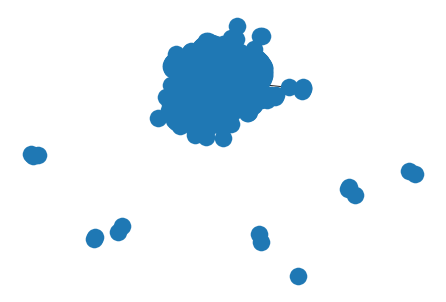

In [272]:
nx.draw(G)